In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_ses.csv

In [0]:
!pip install mlflow
!pip install prophet

  Using cached mlflow-2.16.2-py3-none-any.whl (26.7 MB)
  Using cached SQLAlchemy-2.0.35-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl (85 kB)
  Using cached Markdown-3.7-py3-none-any.whl (106 kB)
  Using cached alembic-1.13.3-py3-none-any.whl (233 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl (5.6 MB)
  Using cached sqlparse-0.5.1-py3-none-any.whl (44 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl (63 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl (110 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl 

In [0]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pyspark.sql import SparkSession
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split


In [0]:
spark = SparkSession.builder \
    .appName("DemandForecastingSES") \
    .getOrCreate()


In [0]:
df = spark.read.csv("dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_ses.csv", header=True, inferSchema=True)


In [0]:
pandas_df = df.toPandas()


In [0]:
pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])  # Convert LastSaleDate to datetime
df_ses = pandas_df[['LastSaleDate', 'Sales']].rename(columns={'LastSaleDate': 'ds', 'Sales': 'y'})

In [0]:
print(df_ses.isnull().sum())

ds    0
y     0
dtype: int64


In [0]:
train_size = int(len(df_ses) * 0.8)
train_df = df_ses[:train_size]
test_df = df_ses[train_size:]

In [0]:
ses_model = SimpleExpSmoothing(train_df['y'])
ses_fit = ses_model.fit()

In [0]:
predictions = ses_fit.forecast(len(test_df))

Mean Absolute Error: 18.29013002615072


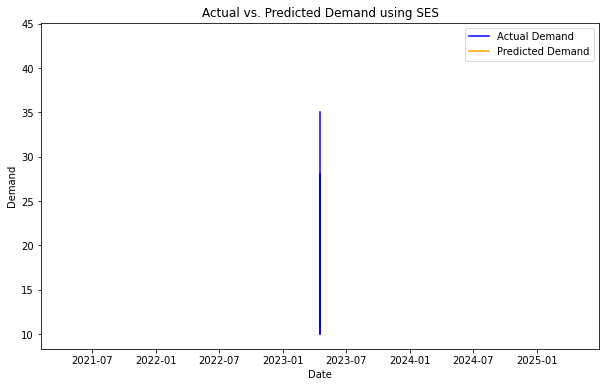

In [0]:
predictions_df = pd.DataFrame({'ds': test_df['ds'], 'yhat': predictions})
predictions_df['mae'] = abs(test_df['y'] - predictions_df['yhat'])
print(f'Mean Absolute Error: {predictions_df["mae"].mean()}')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Demand', color='blue')
plt.plot(predictions_df['ds'], predictions_df['yhat'], label='Predicted Demand', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Predicted Demand using SES')
plt.show()

In [0]:
with mlflow.start_run():
    mlflow.statsmodels.log_model(ses_fit, "ses_model")
    mlflow.log_params({"smoothing_level": ses_fit.model.params['smoothing_level']})

2024/10/07 17:47:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/07 17:47:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-crab-178 at: https://community.cloud.databricks.com/ml/experiments/4498943658609979/runs/57536f0127fc4072b19f00b6af6ee024.
2024/10/07 17:47:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658609979.
